In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [2]:
path = kagglehub.dataset_download("spandan2/cats-faces-64x64-for-generative-models")
print("Path to dataset files:", path)
DATA_DIR = '/root/.cache/kagglehub/datasets/spandan2/cats-faces-64x64-for-generative-models/versions/1'
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

100%|██████████| 96.0M/96.0M [00:05<00:00, 17.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/spandan2/cats-faces-64x64-for-generative-models/versions/1


In [3]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

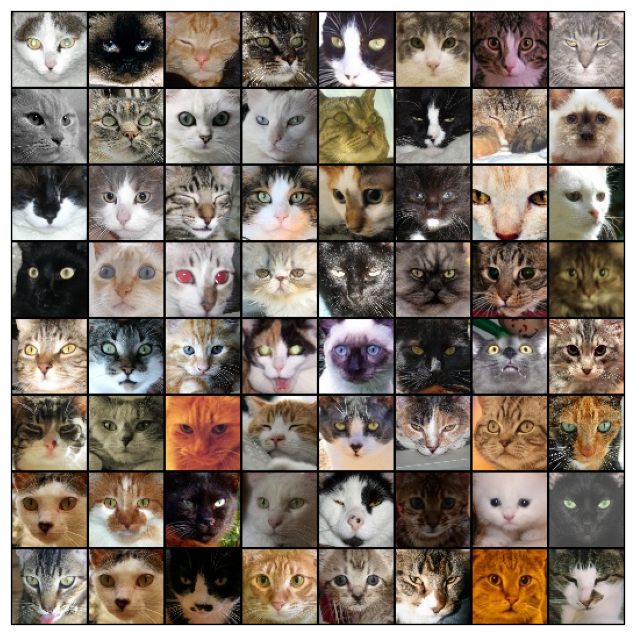

In [4]:
show_batch(train_dl)

In [9]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
train_dl = DeviceDataLoader(train_dl, device)

cuda


In [18]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
    )
discriminator = to_device(discriminator, device)

In [17]:
latent_size = 128
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


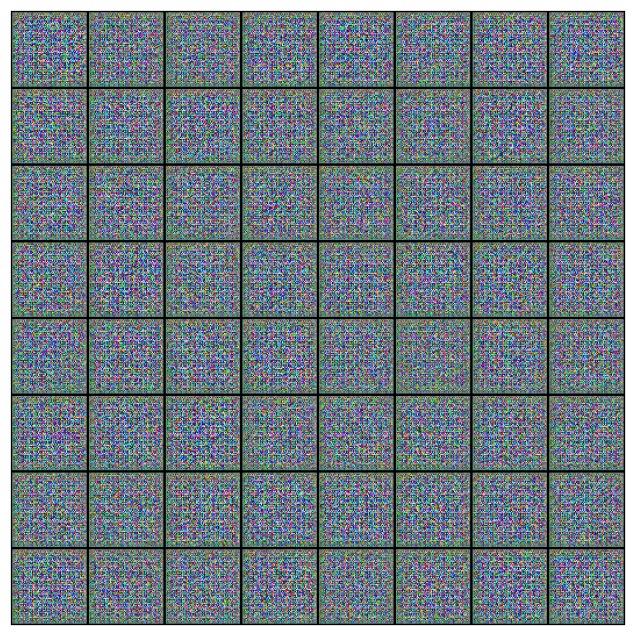

In [16]:
fake_images = generator(xb)
xb = torch.randn(batch_size, latent_size, 1, 1)
print(fake_images.shape)
show_images(fake_images)

In [19]:
generator = to_device(generator, device)
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [20]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            optimizer["discriminator"].zero_grad()

            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            optimizer["generator"].zero_grad()

            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 40
history = fit(model, criterion, epochs, lr)

  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 6.1077, loss_d: 0.5112, real_score: 0.8262, fake_score: 0.1686


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 4.2281, loss_d: 0.6826, real_score: 0.7781, fake_score: 0.2234


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 4.5819, loss_d: 0.6965, real_score: 0.7808, fake_score: 0.2206


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 4.7193, loss_d: 0.6930, real_score: 0.7961, fake_score: 0.2025


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 4.7059, loss_d: 0.6160, real_score: 0.8131, fake_score: 0.1870


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 4.6626, loss_d: 0.5909, real_score: 0.8147, fake_score: 0.1850


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 4.4641, loss_d: 0.5831, real_score: 0.8173, fake_score: 0.1813


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 4.7692, loss_d: 0.5075, real_score: 0.8380, fake_score: 0.1611


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 4.6879, loss_d: 0.5022, real_score: 0.8422, fake_score: 0.1569


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 4.6980, loss_d: 0.4846, real_score: 0.8499, fake_score: 0.1492


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 4.9203, loss_d: 0.4227, real_score: 0.8670, fake_score: 0.1351


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 5.0310, loss_d: 0.4830, real_score: 0.8571, fake_score: 0.1387


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 4.9061, loss_d: 0.4421, real_score: 0.8618, fake_score: 0.1383


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 5.0998, loss_d: 0.4157, real_score: 0.8734, fake_score: 0.1242


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 5.1494, loss_d: 0.3985, real_score: 0.8764, fake_score: 0.1234


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 5.3746, loss_d: 0.3366, real_score: 0.8910, fake_score: 0.1058


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 5.8035, loss_d: 0.3083, real_score: 0.9086, fake_score: 0.0948


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 6.0107, loss_d: 0.3634, real_score: 0.8983, fake_score: 0.1006


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 6.4036, loss_d: 0.3145, real_score: 0.9151, fake_score: 0.0850


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 6.3702, loss_d: 0.2601, real_score: 0.9238, fake_score: 0.0758


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 6.7122, loss_d: 0.2473, real_score: 0.9307, fake_score: 0.0683


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 6.9678, loss_d: 0.2745, real_score: 0.9306, fake_score: 0.0709


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 6.9892, loss_d: 0.2791, real_score: 0.9300, fake_score: 0.0679


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 6.7087, loss_d: 0.2164, real_score: 0.9406, fake_score: 0.0604


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 6.3102, loss_d: 0.2950, real_score: 0.9267, fake_score: 0.0725


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 6.4525, loss_d: 0.1394, real_score: 0.9557, fake_score: 0.0478


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 7.3460, loss_d: 0.2503, real_score: 0.9309, fake_score: 0.0677


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 6.9223, loss_d: 0.2203, real_score: 0.9378, fake_score: 0.0620


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 6.5037, loss_d: 0.2487, real_score: 0.9305, fake_score: 0.0691


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 6.7078, loss_d: 0.2340, real_score: 0.9380, fake_score: 0.0605


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 6.1311, loss_d: 0.2501, real_score: 0.9279, fake_score: 0.0735


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 6.2543, loss_d: 0.2283, real_score: 0.9347, fake_score: 0.0668


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 6.8374, loss_d: 0.1828, real_score: 0.9482, fake_score: 0.0517


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 6.3501, loss_d: 0.2150, real_score: 0.9387, fake_score: 0.0630


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 7.4410, loss_d: 0.1729, real_score: 0.9520, fake_score: 0.0477


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 6.6413, loss_d: 0.1803, real_score: 0.9470, fake_score: 0.0532


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 7.4787, loss_d: 0.1853, real_score: 0.9468, fake_score: 0.0543


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 6.9237, loss_d: 0.1981, real_score: 0.9466, fake_score: 0.0530


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 6.9028, loss_d: 0.1791, real_score: 0.9494, fake_score: 0.0506


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 6.8130, loss_d: 0.2024, real_score: 0.9480, fake_score: 0.0491
Saving generated-images-0040.png


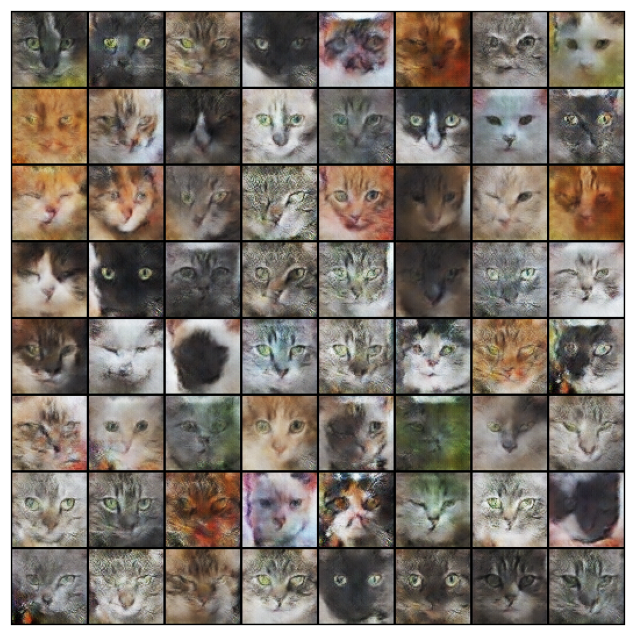

In [21]:
losses_g, losses_d, real_scores, fake_scores = history
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

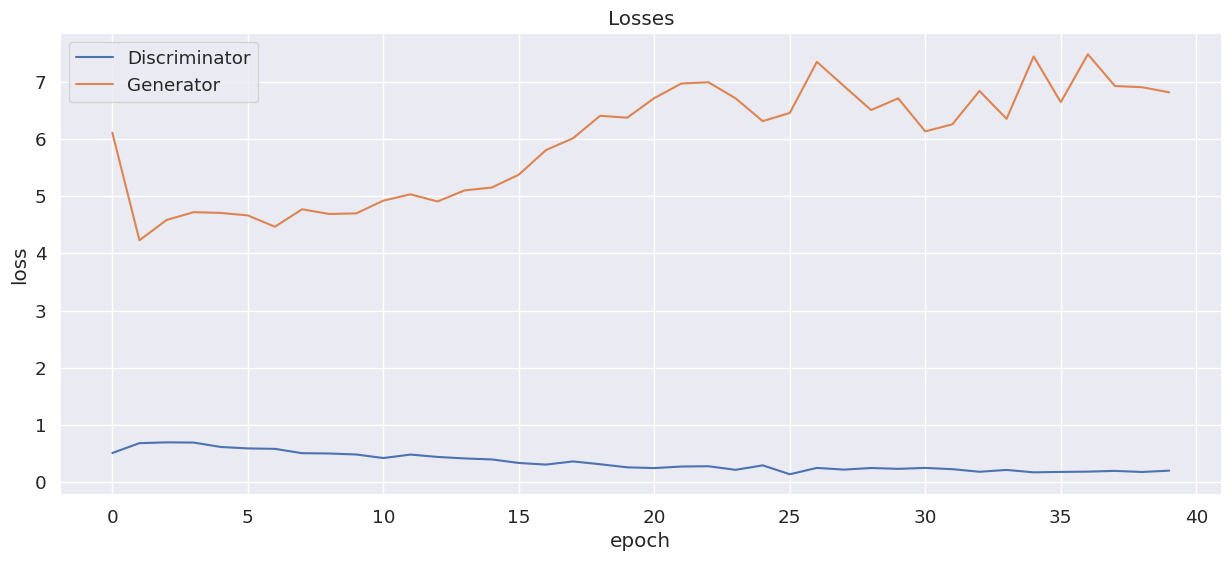

In [22]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

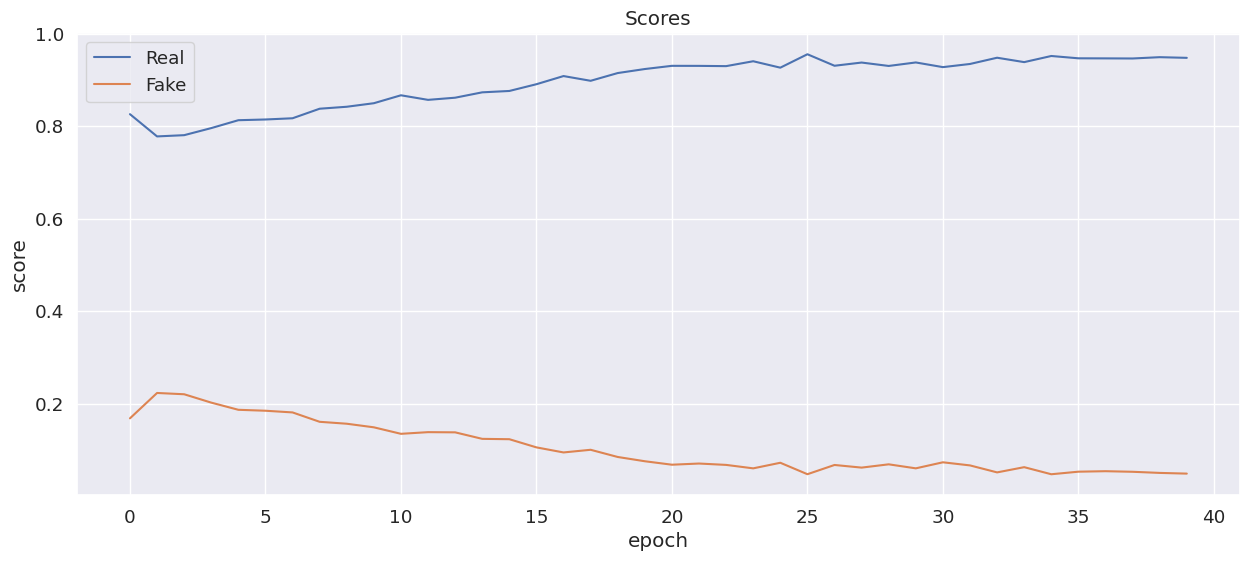

In [23]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');